# Encapsulating common statistical models in Python classes

This document is intended to showcase Python encapsulation of common regression models.  The objectives of developing such a system of encapsulated classes are as follows:
* Uninform handling of formulas
* Convenient access to typical operations used in regression modeling
* Convenient Python access to statistical functions built in R

Class instances easily produce plots such as the following:

<table class="noborder">
    <tr><td style="text-align:center">Simple Linear Regression Line with Error Band</td>
    <td style="text-align:center">Multiple Linear Regression Residual by Predicted</td></tr>
<tr><td><img src='img/eahDataAnalysis-SLR.png'></td>
    <td><img src='img/eahDataAnalysis-ResByPred.png'></td></tr>
<tr><td style="text-align:center">Curve Semi-parametrically Estimated by a GAM</td>
    <td style="text-align:center">Logistic Regression Residual Diagnostics</td></tr>
<tr><td><img src='img/eahDataAnalysis-GAM.png'></td>
    <td><img src='img/eahDataAnalysis-HosmLem.png'></td></tr>
    </table>

Here are some examples of how these classes are used:

```python
# Fit linear regression model (interaction between age and smoking)
ex_OLS = eahLinearModel('fev~age*smoke', fev)

# Summarize the model fitting
print(ex_OLS.summary())

# Plot residuals by prediction
ex_OLS.plot()

# Fit a binary Generalized Additive Model
ex_GAMb = eahGenAddModel('isSmoker~s(age)+sex', fev, 'binomial')

# Plot the non-parametric terms       
ex_GAMb.plotNonParamTerm(0, main='Age')
```

See below for details.

Note that this Jupyter notebook is intended to demonstrate several skills:
* Basic statistical knowledge
* Abstraction of a problem using Python classes
* Ability to integrate R functionality into Python
* Ability to construct simple graphics

In [1]:
###########################
# Load  all necessary packages
###########################

## Standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.axes as axes

## Python Stats
import statsmodels.api as sm
import statsmodels.discrete as smd
import statsmodels.formula.api as smf
from patsy import dmatrices
from scipy.stats import norm
#from sklearn import linear_model

## R interface
# This setting may need to be changed on a different computer
os.putenv('R_USER',"C:\Python36\Lib\site-packages\rpy2")
import rpy2
import rpy2.robjects as Robj
from rpy2.robjects import Formula
from rpy2.robjects.packages import importr

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

mgcv = importr("mgcv") # Necessary for GAM

In [2]:
###########################
# Utility functions
###########################
## Function for creating all dummy variables corresponding to a single categorical
def eahIndicators(x):
    df = pd.DataFrame()
    df['x']=x
    df['y']=np.repeat(0.0, x.shape[0])
    tmp, X = dmatrices('y~x-1', df, return_type="matrix")
    return(X)

###########################
# Model classes
###########################
## Linear model class
class eahLinearModel:
    def __init__(self, formula, data):
        y, X = dmatrices(formula, data, return_type="matrix")
        self.formula = formula
        self.data = data
        self.y = np.array(y)
        self.X = X
        self.model = sm.OLS(y,X)
        self.fit = self.model.fit()
        
    def summary(self):
        return(self.fit.summary())
    
    def coefficients(self):
        return(self.fit.params)
    
    def vcov(self):
        return(self.fit.cov_params())
    
    def vcovRobust(self,vtype=0):
        if vtype==0:
            return(self.fit.cov_HC0)
        elif vtype==1:
            return(self.fit.cov_HC1) 
        elif vtype==2:
            return(self.fit.cov_HC2) 
        else:
            return(self.fit.cov_HC3) 
        
    def predict(self, X=None):
        if X is None:
            X = self.X
        if type(X).__name__=='DataFrame':
            y, X = dmatrices(self.formula, X, return_type="matrix")
        eta = np.dot(X, self.coefficients())
        Sigma2 = self.vcov()
        v = list()
        for x in X:
            Sx = np.dot(x,Sigma2)
            v.append(np.dot(Sx,x))
        se= np.sqrt(np.array(v))
        
        out = pd.DataFrame()
        out['prediction'] = eta
        out['SE'] = se
        return(out)
    
    def plot(self):
        p = np.array(self.predict()['prediction'])
        y = np.array(self.y).reshape(self.y.shape[0])
        r = y - p
        fig, ax = plt.subplots()
        ax.scatter(p,r)
        plt.title('residual by predicted')
        plt.xlabel("predicted")
        plt.ylabel("residual")   
        plt.hlines(0,np.min(p),np.max(p), colors='black', linestyles="dashed")
        plt.show()

## Multiple logistic regression class
class eahLogisticModel(eahLinearModel):
    def __init__(self, formula, data):
        y, X = dmatrices(formula, data, return_type="matrix")
        self.formula = formula
        self.data = data
        self.y = np.array(y)
        self.X = X
        self.model = smd.discrete_model.Logit(y,X)
        self.fit = self.model.fit()
        
    def vcovRobust(self,vtype=0):
        return(self.vcov())
    
    def predictResponse(self, X=None, alpha=0.05):
        pr = self.predict(X)
        out = pd.DataFrame()
        out['prediction'] = 1/(1+np.exp(-pr['prediction'])) 
        z = norm.ppf(1-alpha/2)
        out['C.I. upper'] = 1/(1+np.exp(-pr['prediction'] - z*pr['SE']))
        out['C.I. lower'] = 1/(1+np.exp(-pr['prediction'] + z*pr['SE']))
        return(out)
    
    def plot(self, numQuantiles=5):
        pihat = self.predictResponse()['prediction']
        quantiles = list(np.linspace(0,1,num=numQuantiles+1)*100)
        pihatcat=pd.cut(pihat, np.percentile(pihat,quantiles),
                        labels=False,include_lowest=True) 
                
        meanprobs =[0]*numQuantiles 
        expevents =[0]*numQuantiles
        obsevents =[0]*numQuantiles 
        meanprobs2=[0]*numQuantiles 
        expevents2=[0]*numQuantiles
        obsevents2=[0]*numQuantiles 
        
        seEvents=[0]*numQuantiles
        seEvents2=[0]*numQuantiles
        
        for i in range(numQuantiles):
            meanprobs[i]=np.mean(pihat[pihatcat==i])
            meanprobs2[i]=np.mean(1-pihat[pihatcat==i])
            expevents[i]=np.sum(pihatcat==i)*np.array(meanprobs[i])
            expevents2[i]=np.sum(pihatcat==i)*np.array(meanprobs2[i])
            obsevents[i]=np.sum(self.y[pihatcat==i])
            obsevents2[i]=np.sum(1-self.y[pihatcat==i]) 
            seEvents[i]=np.sqrt(expevents[i])
            seEvents2[i]=np.sqrt(expevents2[i])
            
        fig, ax = plt.subplots()
        ax.plot(expevents,obsevents,'ro',zorder=100)
        ax.plot(expevents2,obsevents2,'bo',zorder=101)
        plt.title('observed by expected')
        plt.xlabel("expected")
        plt.ylabel("observed")   
        xy = [0,pihat.shape[0]]
        for i in range(numQuantiles):
            ax.add_line(lines.Line2D([expevents[i]-2*seEvents[i],
                                     expevents[i]+2*seEvents[i]],[obsevents[i]]*2, 
                                     color='red', linestyle="dashed"))
            ax.add_line(lines.Line2D([expevents2[i]-2*seEvents2[i],
                                     expevents2[i]+2*seEvents2[i]],[obsevents2[i]]*2, 
                                     color='blue', linestyle="dashed")) 
        ax.add_line(lines.Line2D(xy, xy, color='black', linestyle="dotted"))
        lgdBlue = lines.Line2D([], [], color='blue', marker='o', linestyle="dashed",
                          markersize=5, label='failures (+/- 2 SE)')
        lgdRed = lines.Line2D([], [], color='red', marker='o', linestyle="dashed",
                          markersize=5, label='successes (+/- 2 SE)')
        plt.legend(handles=[lgdRed, lgdBlue],loc='best')
        plt.show()
        
## General Additive Model class
class eahGenAddModel:
    def __init__(self, formula, data, family='gaussian'):
        self.formula = formula
        self.data = data
        self.r_dataframe = pandas2ri.py2ri(data)
        self.r_formula = Formula(formula)
        self.r_gam = mgcv.gam(self.r_formula, data=self.r_dataframe, family=family)
        self.plotInfo = None
        
    def summary(self):
        return(Robj.r.summary(self.r_gam))
    
    def coefficients(self):
        return(Robj.r.coef(self.r_gam))
    
    def vcov(self):
        return(Robj.r.vcov(self.r_gam))
    
    def vcovRobust(self,vtype=0):
        return(self.vcov()) 
        
    def predict(self, X=None):
        if X is None:
            pr = Robj.r.predict(self.r_gam, self.r_dataframe, "link", True)
        elif type(X).__name__=='DataFrame':
            pr = Robj.r.predict(self.r_gam, pandas2ri.py2ri(X), "link", True)
        else:
            raise Exception("X must be a DataFrame.")
        out = pd.DataFrame()
        out['prediction'] = np.array(pr[0])
        out['SE'] = np.array(pr[1])
        return(out)
    
    def plot(self):
        p = np.array(self.predict()['prediction'])
        y = np.array(Robj.r.get('y',self.r_gam))
        r = y - p
        fig, ax = plt.subplots()
        ax.scatter(p,r)
        plt.title('residual by predicted')
        plt.xlabel("predicted")
        plt.ylabel("residual")   
        plt.hlines(0,np.min(p),np.max(p), colors='black', linestyles="dashed")
        plt.show()

    def plotNonParamTerm(self, select=0, xlabel=None, ylabel='Spline Fit', main='',
                         colorRug='black', colorLine='red', colorBG='pink'):
        if self.plotInfo is None:
            # Note:  this has the unfortunate side effect of creating an
            # empty R plot window which is otherwise inaccessible and if you
            # try to close it, the kernel will crash :-(
            # I don't yet know how to fix this because this behavior is the result
            # of plot.gam in R, which gives no way to suppress the device.
            self.plotInfo = Robj.r.plot(self.r_gam, select=0)
        
        if xlabel is None:
            # Default:  use the term specified in the R GAM object
            xlabel = list(Robj.r.get('term',Robj.r.get('smooth',self.r_gam)[select]))[0]
            
        yhat = np.array(Robj.r.get('fit', self.plotInfo[select]))[:,0] + self.coefficients()[0]
        x = np.array(Robj.r.get('x', self.plotInfo[select]) )
        se = np.array(Robj.r.get('se', self.plotInfo[select]) )
        xset = list(set(Robj.r.get('raw', self.plotInfo[select])))
        
        fig, ax = plt.subplots()
        ax.plot(x,yhat,color=colorLine, zorder=100)
        plt.title(main)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        ax.fill(list(x)+list(reversed(x)),list(yhat+2*se)+list(reversed(yhat-2*se)),
                color=colorBG)
        ax.plot(xset, [ax.get_ylim()[0]]*len(xset), '|', color=colorRug)
        plt.show()

## Simple linear regression class
class eahSimpleLinearModel(eahLinearModel):
    def __init__(self, y, x):
        self.data = pd.DataFrame()
        self.data['x'] = np.array(x)
        self.data['y'] = np.array(y)
        
        nx = x.shape[0]
        one = np.repeat(1.0,nx).reshape(nx,1)

        self.y = np.array(y)
        self.X = np.concatenate((one,np.array(x).reshape(nx,1)),axis=1)
        self.model = sm.OLS(self.y,self.X)
        self.fit = self.model.fit()
        self.formula = 'y~x'
        
    def summary(self):
        return(self.fit.summary())
    
    def coefficients(self):
        return(self.fit.params)
    
    def vcov(self):
        return(self.fit.cov_params())
    
    def vcovRobust(self,vtype=0):
        if vtype==0:
            return(self.fit.cov_HC0)
        elif vtype==1:
            return(self.fit.cov_HC1) 
        else:
            return(self.fit.cov_HC2) 
        
    def predict(self, X=None):
        if X is None:
            X = self.X
        if type(X).__name__=='DataFrame':
            y, X = dmatrices(self.formula, X, return_type="matrix")
        eta = np.dot(X, self.coefficients())
        Sigma2 = self.vcov()
        v = list()
        for x in X:
            Sx = np.dot(x,Sigma2)
            v.append(np.dot(Sx,x))
        se= np.sqrt(np.array(v))
        
        out = pd.DataFrame()
        out['prediction'] = eta
        out['SE'] = se
        return(out)
    
    def plot(self, xlabel='x', ylabel='y', main='', colorData='black', colorLine='red', colorBG='pink'):
        
        xp = np.linspace(np.min(self.data['x']),np.max(self.data['x']),num=101).reshape(101)
        dp = pd.DataFrame()
        dp['x'] = xp
        dp['y'] = np.repeat(0, 101)
        pp = self.predict(dp)
        ppy = pp['prediction']
        pps = pp['SE']
        fig, ax = plt.subplots()
        ax.scatter(self.data['x'],self.data['y'],color=colorData, zorder=100)
        plt.title(main)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        ax.fill(list(xp)+list(reversed(xp)),list(ppy+2*pps)+list(reversed(ppy-2*pps)),color=colorBG)
        ax.add_line(lines.Line2D(xp,ppy,color=colorLine))
        plt.show()



In [3]:
###########################
# Load data used for examples
###########################
import os  # Just in case this package wasn't already loaded
os.chdir("C:/Users/eahou/Dropbox/OSU/H580") # Directory containing data
fev = pd.read_csv('FEV.csv') # Data set containing FEV measured on children

# Get an indicator variable for smoking
fev['isSmoker'] = eahIndicators(fev["smoke"])[:,0]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     872.2
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          2.45e-122
Time:                        18:18:24   Log-Likelihood:                -556.51
No. Observations:                 654   AIC:                             1117.
Df Residuals:                     652   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4316      0.078      5.541      0.0

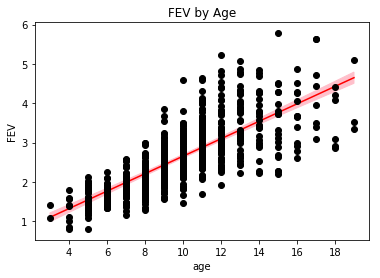

Regression coefficients:
[0.43164811 0.22204098]


In [4]:
###########################
# Simple linear regression 
#   (just specify y and x)
###########################

# Fit model
ex_SLR = eahSimpleLinearModel(fev['fev'],fev['age'])

# Analysis summary
print(ex_SLR.summary())

# Plot Y by X, with regression line and error band
ex_SLR.plot('age','FEV','FEV by Age')

# Get just the coefficients
print('Regression coefficients:')
print(ex_SLR.coefficients())

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     317.1
Date:                Thu, 11 Jul 2019   Prob (F-statistic):          8.66e-127
Time:                        18:18:24   Log-Likelihood:                -539.37
No. Observations:                 654   AIC:                             1087.
Df Residuals:                     650   BIC:                             1105.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

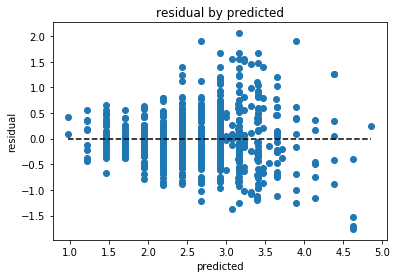

Regression coefficients:
[ 2.19696626 -1.94357074  0.07985574  0.16270267]

Covariance of parameters (non-robust):
[[ 0.16480061 -0.16480061 -0.01183785  0.01183785]
 [-0.16480061  0.17163175  0.01183785 -0.0124997 ]
 [-0.01183785  0.01183785  0.00087538 -0.00087538]
 [ 0.01183785 -0.0124997  -0.00087538  0.0009448 ]]

Implied standard errors:
[0.40595641 0.41428463 0.02958684 0.03073753]

Robust standard errors (White 1980):
[0.44784448 0.45596305 0.03273293 0.03420287]

Robust standard errors (Robust, MacKinnon & White 1985):
[0.44922035 0.45736386 0.03283349 0.03430795]

Some predictions:
   prediction        SE
0    2.436421  0.023245
1    2.193863  0.026154
2    1.951304  0.031089
3    2.436421  0.023245
4    2.436421  0.023245
5    2.193863  0.026154
6    1.708746  0.037253
7    1.708746  0.037253
8    2.193863  0.026154
9    2.436421  0.023245


In [5]:
###########################
# Multiple linear regression
#  (Ordinary Least Squares)
###########################

# Fit model (interaction between age and smoking)
ex_OLS = eahLinearModel('fev~age*smoke', fev)

# Analysis summary
print(ex_OLS.summary())

# Plot residuals by prediction
ex_OLS.plot()

# Get just the coefficients
print('Regression coefficients:')
print(ex_OLS.coefficients())

# Get the variance covariance matrix
print('\nCovariance of parameters (non-robust):')
print(ex_OLS.vcov())

# Get the corresponding standard errors
print('\nImplied standard errors:')
print(np.sqrt(np.diagonal(ex_OLS.vcov())))

# Get two types of robust covariance matrices
print('\nRobust standard errors (White 1980):')
print(np.sqrt(np.diagonal(ex_OLS.vcovRobust(0))))

print('\nRobust standard errors (Robust, MacKinnon & White 1985):')
print(np.sqrt(np.diagonal(ex_OLS.vcovRobust(1))))

# Get predictions with standard errors
pr_OLS = ex_OLS.predict()
print('\nSome predictions:')
print(pr_OLS[0:10])


In [6]:
###########################
# Multiple linear regression
#  (Prediction from new data)
###########################

# Create a prediction frame
predF = pd.DataFrame()

# Ages 3 to 19, 2 copies (one for each smoking status)
predF['age'] = np.concatenate((np.linspace(3.0,19.0,num=17),
                               np.linspace(3.0,19.0,num=17)))
predF['smoke'] = pd.Series(['non-current smoker']*17 +
                           ['current smoker']*17)

# Note:  non-missing response values needs to be in this frame
#   even though we are predicting the response!  Just use zero.
predF['fev'] = pd.Series([0]*34) 

# Now get the predictions
pr_OLS2 = ex_OLS.predict(predF)

# Show predictions for all non-smokers 
flag = list((predF.smoke=='non-current smoker'))
predsNS = pd.DataFrame()
predsNS['age'] = predF['age'][flag]
predsNS['pred fev'] = pr_OLS2[flag]['prediction']
predsNS['pred SE'] = pr_OLS2[flag]['SE']
print('Predictions for Non-Smokers')
print(predsNS)

# Show predictions for smokers over 8
flag = list((predF.age>8) & (predF.smoke=='current smoker'))
predsS = pd.DataFrame()
predsS['age'] = predF['age'][flag]
predsS['pred fev'] = pr_OLS2[flag]['prediction']
predsS['pred SE'] = pr_OLS2[flag]['SE']
print('\nPredictions for Smokers')
print(predsS)

Predictions for Non-Smokers
     age  pred fev   pred SE
0    3.0  0.981071  0.059032
1    4.0  1.223629  0.051448
2    5.0  1.466188  0.044136
3    6.0  1.708746  0.037253
4    7.0  1.951304  0.031089
5    8.0  2.193863  0.026154
6    9.0  2.436421  0.023245
7   10.0  2.678980  0.023141
8   11.0  2.921538  0.025875
9   12.0  3.164096  0.030698
10  13.0  3.406655  0.036797
11  14.0  3.649213  0.043640
12  15.0  3.891772  0.050929
13  16.0  4.134330  0.058497
14  17.0  4.376889  0.066249
15  18.0  4.619447  0.074126
16  19.0  4.862005  0.082093

Predictions for Smokers
     age  pred fev   pred SE
23   9.0  2.915668  0.150417
24  10.0  2.995524  0.124827
25  11.0  3.075379  0.101435
26  12.0  3.155235  0.082141
27  13.0  3.235091  0.070399
28  14.0  3.314947  0.070111
29  15.0  3.394802  0.081400
30  16.0  3.474658  0.100434
31  17.0  3.554514  0.123689
32  18.0  3.634370  0.149203
33  19.0  3.714225  0.175997


Optimization terminated successfully.
         Current function value: 0.238287
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               isSmoker   No. Observations:                  654
Model:                          Logit   Df Residuals:                      651
Method:                           MLE   Df Model:                            2
Date:                Thu, 11 Jul 2019   Pseudo R-squ.:                  0.2639
Time:                        18:18:25   Log-Likelihood:                -155.84
converged:                       True   LL-Null:                       -211.72
                                        LLR p-value:                 5.369e-25
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -7.5861      0.721    -10.528      0.000      -8.998      -6.174
sex[T.male]    -0.7929    

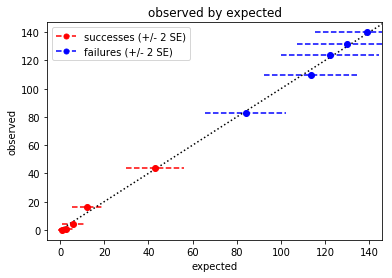

Regression coefficients:
[-7.58607223 -0.79293621  0.50086969]

Covariance of parameters:
[[ 0.5191852   0.0015808  -0.03957476]
 [ 0.0015808   0.0949825  -0.00328906]
 [-0.03957476 -0.00328906  0.00325737]]

Implied standard errors:
[0.72054507 0.30819231 0.05707334]

Some predictions on the scale of the link function:
   prediction        SE
0   -3.078245  0.265869
1   -3.579115  0.307344
2   -4.079984  0.353199
3   -3.871181  0.331100
4   -3.871181  0.331100
5   -3.579115  0.307344
6   -4.580854  0.401937
7   -4.580854  0.401937
8   -3.579115  0.307344
9   -3.078245  0.265869

Some predictions on the scale of the link function:
   prediction  C.I. upper  C.I. lower
0    0.044014    0.071947    0.026614
1    0.027143    0.048488    0.015046
2    0.016627    0.032681    0.008390
3    0.020409    0.038337    0.010770
4    0.020409    0.038337    0.010770
5    0.027143    0.048488    0.015046
6    0.010142    0.022030    0.004639
7    0.010142    0.022030    0.004639
8    0.027143    0.

In [7]:
###########################
# Logistic Regression
###########################

# Fit model (smoking by age and sex)
ex_LogR = eahLogisticModel('isSmoker~age+sex', fev)

# Analysis summary
print(ex_LogR.summary())

# Plot observed vs. expected
#  as in a Hosmer-Lemeshow test
ex_LogR.plot(numQuantiles=5)

# Get just the coefficients
print('Regression coefficients:')
print(ex_LogR.coefficients())

# Get the variance covariance matrix
print('\nCovariance of parameters:')
print(ex_LogR.vcov())

# Get the corresponding standard errors
print('\nImplied standard errors:')
print(np.sqrt(np.diagonal(ex_LogR.vcov())))

# Show some predictions (on the link scale)
pr_LogR = ex_LogR.predict()
print('\nSome predictions on the scale of the link function:')
print(pr_LogR[0:10])

# Show some predictions (on the response scale)
pr_LogR2 = ex_LogR.predictResponse()
print('\nSome predictions on the scale of the link function:')
print(pr_LogR2[0:10])


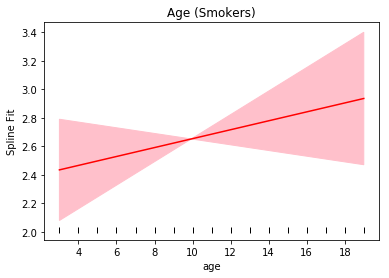

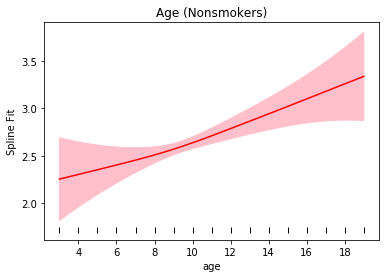

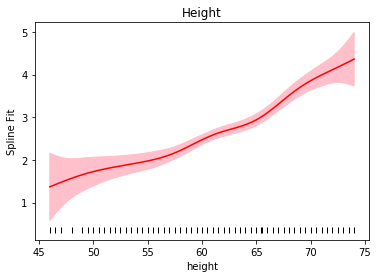

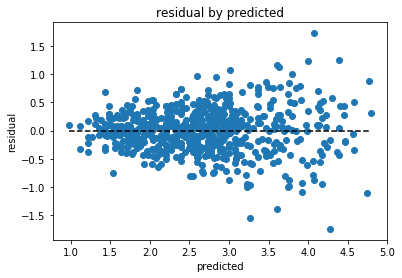



Family: gaussian 

Link function: identity 



Formula:

fev ~ s(age, by = factor(smoke)) + s(height)



Parametric coefficients:

            Estimate Std. Error t value Pr(>|t|)    

(Intercept)  2.65110    0.01618   163.9   <2e-16 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Approximate significance of smooth terms:

                                         edf Ref.df     F  p-value    

s(age):factor(smoke)current smoker     1.000  1.000  5.97   0.0148 *  

s(age):factor(smoke)non-current smoker 1.861  2.398 22.77 2.83e-11 ***

s(height)                              6.646  7.750 83.07  < 2e-16 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



R-sq.(adj) =  0.795   Deviance explained = 79.7%

GCV = 0.15701  Scale est. = 0.15449   n = 654

Regression coefficients:
                             (Intercept) 

                            2.651103e+00 

    s(age):factor(smoke)current smoker.1 

                            2.34166

In [8]:
###########################
# Generalized Additive Model 
#  (Gaussian)
###########################

# Fit model (smooth interaction between age and smoking, smooth in height)
ex_GAM = eahGenAddModel('fev~s(age,by=factor(smoke))+s(height)', fev)

# Plot the non-parametric terms       
ex_GAM.plotNonParamTerm(0, main='Age (Smokers)')
ex_GAM.plotNonParamTerm(1, main='Age (Nonsmokers)')
ex_GAM.plotNonParamTerm(2, main='Height')

# Plot residuals by prediction
ex_GAM.plot()

# Analysis summary
print(ex_GAM.summary())

# Get just the coefficients
print('Regression coefficients:')
print(ex_GAM.coefficients())



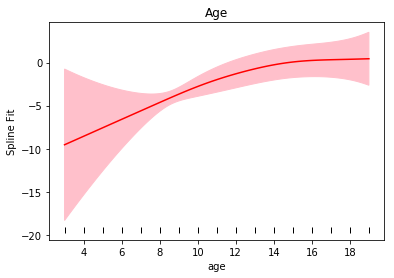



Family: binomial 

Link function: logit 



Formula:

isSmoker ~ s(age) + sex



Parametric coefficients:

            Estimate Std. Error z value Pr(>|z|)    

(Intercept)  -3.2118     0.3976  -8.077 6.63e-16 ***

sexmale      -0.7435     0.3021  -2.461   0.0139 *  

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Approximate significance of smooth terms:

         edf Ref.df Chi.sq  p-value    

s(age) 2.521  3.185   64.6 3.22e-13 ***

---

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



R-sq.(adj) =  0.213   Deviance explained = 29.5%

UBRE = -0.52954  Scale est. = 1         n = 654



In [9]:
###########################
# Generalized Additive Model 
#  (Binomial)
###########################

# Fit model (sex & smooth age)
ex_GAMb = eahGenAddModel('isSmoker~s(age)+sex', fev, 'binomial')

# Plot the non-parametric terms       
ex_GAMb.plotNonParamTerm(0, main='Age')

# Analysis summary
print(ex_GAMb.summary())